In [ ]:
# from
# https://www.kaggle.com/code/nassimyagoub/gan-anime-faces

In [1]:
# import glob
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

from tensorflow.compat.v1.keras.layers import BatchNormalization

# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version


import sys
import os

OpenCV: 4.7.0
matplotlib: 3.6.3
graphviz: 0.20.1


In [2]:
main_dir=os.path.dirname(sys.path[0])

In [3]:
# Specify the location of images after you have downloaded them
ImgLocation = main_dir + "/HW32_Myshkavets S.A./images"

# Create a list to store image paths
ImagePaths=[]
for image in list(os.listdir(ImgLocation)):
    if image != '.DS_Store':
        ImagePaths = ImagePaths + [ImgLocation + "/" + image]
        
# Load images and resize to 64 x 64
data_lowres=[]
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_lowres = cv2.resize(image, (64, 64))
    data_lowres.append(image_lowres)

# Convert image data to numpy array and standardize values (divide by 255 since RGB values ranges from 0 to 255)
# for i in range(len(data_lowres)):
#     data_lowres[i] = ((data_lowres[i] - data_lowres[i].min())/(255 - data_lowres[i].min()))
#     data_lowres[i] = data_lowres[i]*2-1

images = np.array(data_lowres)

# # Show data shape
# print("Shape of data_lowres: ", train_data.shape)

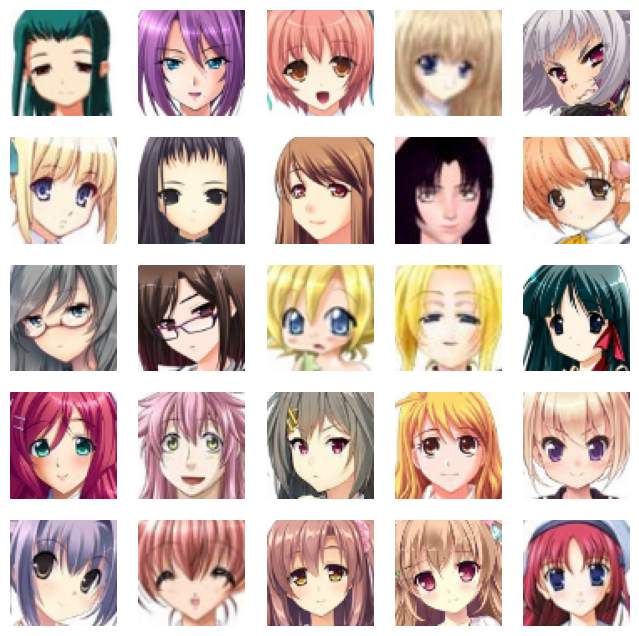

In [4]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

In [5]:
class GAN():
    def __init__(self):
        self.img_shape = (64, 64, 3)
        
        self.noise_size = 100

        optimizer = Adam(0.0002,0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined.summary()
        
    # Creating the generator, the large kernels in the convolutional layers allow the network to create complex structures.
    def build_generator(self):
        epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
        noise_shape = (self.noise_size,)
        
        model = Sequential()
        
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))
        
        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

        # Standard activation for the generator of a GAN
        model.add(Activation("tanh"))
        
        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, metrics_update=50, save_images=100, save_model=2000):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)
        
        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)

            # Training the discriminator
            
            # The loss of the discriminator is the mean of the losses while training on authentic and fake images
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            # Training the generator
            for _ in range(2):
                noise = np.random.normal(0, 1, (batch_size, self.noise_size))

                valid_y = np.array([1] * batch_size)
                g_loss = self.combined.train_on_batch(noise, valid_y)
            
            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss
            
            # We print the losses and accuracy of the networks every 200 batches mainly to make sure the accuracy of the discriminator
            # is not stable at around 50% or 100% (which would mean the discriminator performs not well enough or too well)
            if epoch % metrics_update == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                mean_d_loss=[0,0]
                mean_g_loss=0
            
            # Saving 25 images
            if epoch % save_images == 0:
                self.save_images(epoch)
            
            # We save the architecture of the model, the weights and the state of the optimizer
            # This way we can restart the training exactly where we stopped
            if epoch % save_model == 0:
                self.generator.save("generator_%d" % epoch)
                self.discriminator.save("discriminator_%d" % epoch)

    # Saving 25 generated images to have a representation of the spectrum of images created by the generator
    def save_images(self, epoch):
        
        output_path = 'animeGenerated'
        if not os.path.exists(output_path):
            os.makedirs(output_path)
            
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        
        # Rescale from [-1,1] into [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        
        fig.savefig("animeGenerated/Faces_%d.png" % epoch)
        plt.close()


Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)      

2023-04-06 07:50:00.859103: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-06 07:50:00.859565: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        4194816   
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 512)        

2023-04-06 07:50:02.045749: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-06 07:50:02.161669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 38ms/step


2023-04-06 07:50:02.768972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-06 07:50:05.501997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0 [Discriminator loss: 0.026157, acc.: 0.05%] [Generator loss: 0.000336]
1/1 [==============================] - 0s 111ms/step


2023-04-06 07:50:12.469987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


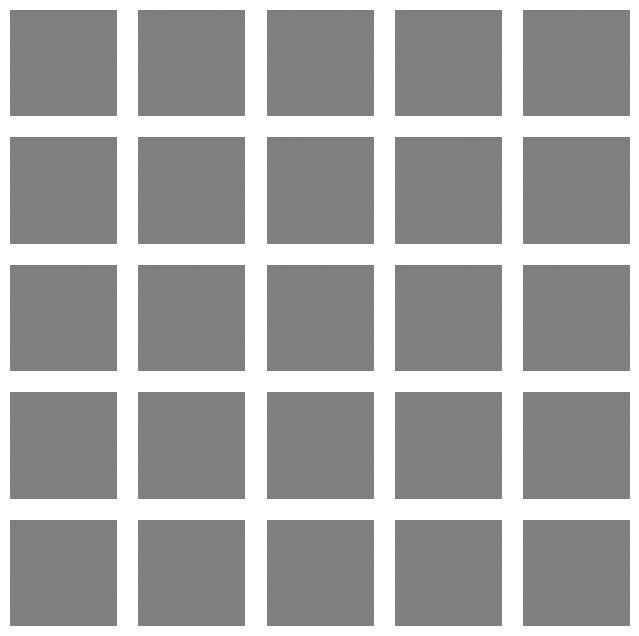

INFO:tensorflow:Assets written to: generator_0/assets


INFO:tensorflow:Assets written to: generator_0/assets


INFO:tensorflow:Assets written to: discriminator_0/assets


INFO:tensorflow:Assets written to: discriminator_0/assets


4/4 [==============================] - 0s 51ms/step


4/4 [==============================] - 0s 50ms/step
200 [Discriminator loss: 0.671434, acc.: 64.17%] [Generator loss: 1.395299]
4/4 [==============================] - 0s 51ms/step


4/4 [==============================] - 0s 51ms/step
400 [Discriminator loss: 0.664450, acc.: 61.58%] [Generator loss: 1.212642]
4/4 [==============================] - 0s 50ms/step


4/4 [==============================] - 0s 51ms/step
600 [Discriminator loss: 0.642323, acc.: 63.18%] [Generator loss: 1.184700]
4/4 [==============================] - 0s 51ms/step


4/4 [==============================] - 0s 51ms/step


4/4 [==============================] - 0s 50ms/step
800 [Discriminator loss: 0.627095, acc.: 64.73%] [Generator loss: 1.348912]
4/4 [==============================] - 0s 50ms/step


4/4 [==============================] - 0s 50ms/step
1000 [Discriminator loss: 0.620193, acc.: 65.63%] [Generator loss: 1.439711]
1/1 [==============================] - 0s 48ms/step


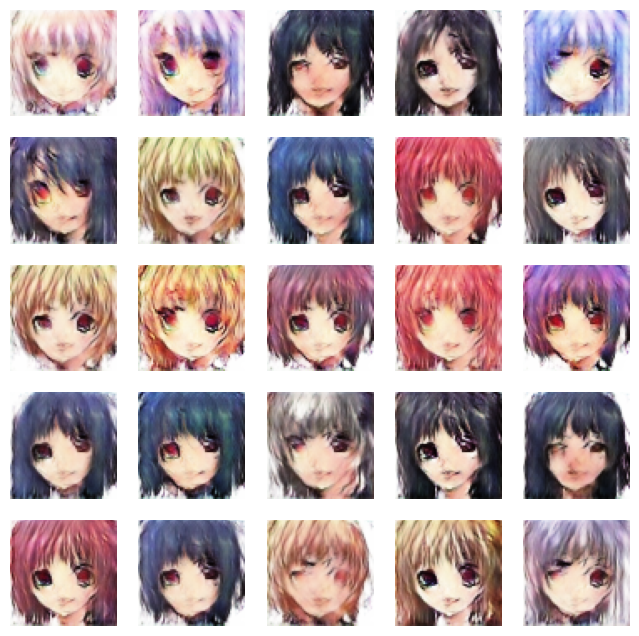

4/4 [==============================] - 0s 55ms/step


4/4 [==============================] - 0s 50ms/step
1200 [Discriminator loss: 0.655864, acc.: 60.78%] [Generator loss: 1.338402]
4/4 [==============================] - 0s 54ms/step


4/4 [==============================] - 0s 50ms/step
1400 [Discriminator loss: 0.649381, acc.: 61.58%] [Generator loss: 1.347079]
4/4 [==============================] - 0s 50ms/step


4/4 [==============================] - 0s 50ms/step
1600 [Discriminator loss: 0.660718, acc.: 60.40%] [Generator loss: 1.320206]
4/4 [==============================] - 0s 49ms/step


4/4 [==============================] - 0s 50ms/step


4/4 [==============================] - 0s 49ms/step
1800 [Discriminator loss: 0.645894, acc.: 62.13%] [Generator loss: 1.346055]
4/4 [==============================] - 0s 50ms/step


4/4 [==============================] - 0s 50ms/step
2000 [Discriminator loss: 0.645513, acc.: 62.13%] [Generator loss: 1.375149]
1/1 [==============================] - 0s 36ms/step


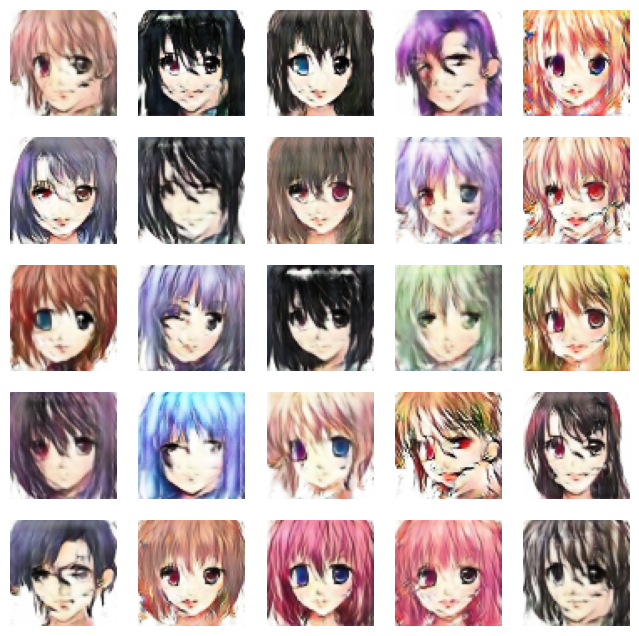

4/4 [==============================] - 0s 50ms/step


4/4 [==============================] - 0s 50ms/step
2200 [Discriminator loss: 0.633579, acc.: 63.53%] [Generator loss: 1.454562]
4/4 [==============================] - 0s 51ms/step


4/4 [==============================] - 0s 55ms/step
2400 [Discriminator loss: 0.615555, acc.: 65.56%] [Generator loss: 1.571339]
4/4 [==============================] - 0s 51ms/step


4/4 [==============================] - 0s 52ms/step
2600 [Discriminator loss: 0.616210, acc.: 65.79%] [Generator loss: 1.578557]
4/4 [==============================] - 0s 50ms/step


4/4 [==============================] - 0s 51ms/step


4/4 [==============================] - 0s 50ms/step
2800 [Discriminator loss: 0.614299, acc.: 65.60%] [Generator loss: 1.581220]
4/4 [==============================] - 0s 50ms/step


4/4 [==============================] - 0s 50ms/step
3000 [Discriminator loss: 0.605790, acc.: 66.64%] [Generator loss: 1.609946]
1/1 [==============================] - 0s 42ms/step


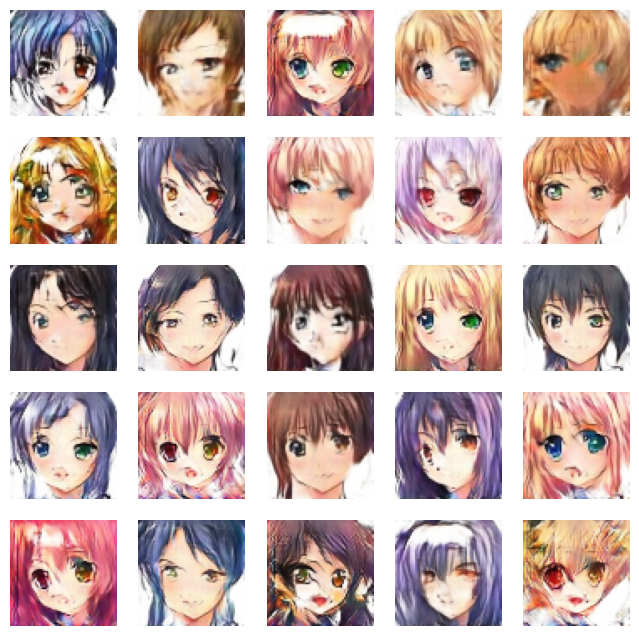

4/4 [==============================] - 0s 52ms/step


KeyboardInterrupt: 

In [6]:
gan=GAN()
gan.train(epochs=15001, batch_size=256, metrics_update=200, save_images=1000, save_model=15000)